In [5]:
import pandas as pd
import numpy as np
import requests
import re
import matplotlib.pyplot as plt
import seaborn as sns
import io
import json

In [ ]:
poke_url = 'https://pokeapi.co/api/v2/pokemon/'

In [ ]:
r2 = requests.get(poke_url)

In [ ]:
pokemon_name_list = [requests.get(poke_url + str(i+1) + '/').json()['name'] for i in range(0, 1010)]

In [ ]:
base_stats_list = [j['base_stat'] for i in range(0, 1010) for j in requests.get(poke_url + str(i+1)).json()['stats']]

In [ ]:
hp_stat = []
attack_stat = []
defense_stat = []
special_attack_stat = []
special_defense_stat = []
speed_stat = []

for i in range(len(base_stats_list)):
    if i % 6 == 0:
        hp_stat.append(base_stats_list[i])
    elif i % 6 == 1:
        attack_stat.append(base_stats_list[i])
    elif i % 6 == 2:
        defense_stat.append(base_stats_list[i])
    elif i % 6 == 3:
        special_attack_stat.append(base_stats_list[i])
    elif i % 6 == 4:
        special_defense_stat.append(base_stats_list[i])
    else:
        speed_stat.append(base_stats_list[i])

In [ ]:
len(requests.get('https://pokeapi.co/api/v2/pokemon/charizard').json()['types'])

In [ ]:
requests.get('https://pokeapi.co/api/v2/pokemon/charizard').json()['types'][0]['type']['name']

In [ ]:
requests.get('https://pokeapi.co/api/v2/pokemon/squirtle').json()['types']

In [ ]:
type1 = []
type2 = []

for t in range(1010):
    if len(requests.get('https://pokeapi.co/api/v2/pokemon/' + str(t+1) + '/').json()['types']) == 1:
        type1.append(requests.get('https://pokeapi.co/api/v2/pokemon/' + str(t+1) + '/').json()['types'][0]['type']['name'])
        type2.append('')
    else:
        type1.append(requests.get('https://pokeapi.co/api/v2/pokemon/' + str(t+1) + '/').json()['types'][0]['type']['name'])
        type2.append(requests.get('https://pokeapi.co/api/v2/pokemon/' + str(t+1) + '/').json()['types'][1]['type']['name'])

In [ ]:
dictionary = {"Pokemon Name" : pokemon_name_list, "Type 1" : type1, "Type 2" : type2, "hp" : hp_stat, "attack" : attack_stat, "defense" : defense_stat,
             "special attack" : special_attack_stat, "special defense" : special_defense_stat, "speed" : speed_stat}
pokemon_df = pd.DataFrame(dictionary)

In [3]:
pokemon_df.to_csv('pokemon_type_and_base_stats.csv', index=False)

NameError: name 'pokemon_df' is not defined

In [35]:
pokemon_df_stat_combos = pokemon_df.copy()
pokemon_df_stat_combos['attack and special attack'] = pokemon_df_stat_combos['attack'] + pokemon_df_stat_combos['special attack']
pokemon_df_stat_combos['defense and special defense'] = pokemon_df_stat_combos['defense'] + pokemon_df_stat_combos['special defense']
pokemon_df_stat_combos['attack and speed'] = pokemon_df_stat_combos['attack'] + pokemon_df_stat_combos['speed']
pokemon_df_stat_combos['special attack and speed'] = pokemon_df_stat_combos['special attack'] + pokemon_df_stat_combos['speed']
pokemon_df_stat_combos.drop(['attack', 'defense', 'special attack', 'special defense', 'speed'], axis=1, inplace=True)

In [36]:
pokemon_df_stat_combos.to_csv('pokemon_type_and_base_stats_combos.csv', index=False)

,Type 1,hp,attack and special attack,defense and special defense,attack and speed,special attack and speed
0,grass,45,114,114,94,110
1,grass,60,142,143,122,140
2,grass,80,182,183,162,180
3,fire,39,112,93,117,125
4,fire,58,144,123,144,160


In [41]:
pokemon_df_stat_ratios = pokemon_df.copy()
pokemon_df_stat_ratios['hp / speed'] = pokemon_df_stat_ratios['hp'] / pokemon_df_stat_ratios['speed']
pokemon_df_stat_ratios['attack / speed'] = pokemon_df_stat_ratios['attack'] / pokemon_df_stat_ratios['speed']
pokemon_df_stat_ratios['defense / speed'] = pokemon_df_stat_ratios['defense'] / pokemon_df_stat_ratios['speed']
pokemon_df_stat_ratios['special attack / speed'] = pokemon_df_stat_ratios['special attack'] / pokemon_df_stat_ratios['speed']
pokemon_df_stat_ratios['special defense / speed'] = pokemon_df_stat_ratios['special defense'] / pokemon_df_stat_ratios['speed']
pokemon_df_stat_ratios.drop(['hp', 'attack', 'defense', 'special attack', 'special defense', 'speed'], axis=1, inplace=True)

In [42]:
pokemon_df_stat_ratios.to_csv('pokemon_type_and_base_stats_ratios.csv', index=False)
pokemon_df_stat_ratios.head()

,Type 1,hp / speed,attack / speed,defense / speed,special attack / speed,special defense / speed
0,grass,1.000,1.088889,1.088889,1.444444,1.444444
1,grass,1.000,1.033333,1.050000,1.333333,1.333333
2,grass,1.000,1.025000,1.037500,1.250000,1.250000
3,fire,0.600,0.800000,0.661538,0.923077,0.769231
4,fire,0.725,0.800000,0.725000,1.000000,0.812500


In [6]:
pokemon_df = pd.read_csv('pokemon_type_and_base_stats.csv')
pokemon_df_combos = pd.read_csv('pokemon_type_and_base_stats_combos.csv')
pokemon_df_ratios = pd.read_csv('pokemon_type_and_base_stats_ratios.csv')

In [7]:
from pathlib import Path
import os

path1 = Path('images/images')

# create a list of the file paths that end in .png
files_paths = list(path1.glob('*.png'))

# list comprehension that gets the second element of each tuple of the split path ([pokemon_name].png)
names = [os.path.split(x)[1] for x in files_paths]

# concatenate names list and files_paths list
image_df = pd.concat([pd.Series(names, name='Name'), pd.Series(files_paths, name='Filepath').astype(str)], axis=1)

# regex matches the file extension
image_df['Name'] = image_df['Name'].apply(lambda x: re.sub(r'\.\w+$', '', x))
image_df.head()

,Name,Filepath
0,abomasnow,images\images\abomasnow.png
1,abra,images\images\abra.png
2,absol,images\images\absol.png
3,accelgor,images\images\accelgor.png
4,aegislash-blade,images\images\aegislash-blade.png


In [8]:
pokemon = pd.read_csv('pokemon.csv')
pokemon.head()

# merge image_df and pokemon data frames on the "Name" column
df = image_df.merge(pokemon, on='Name')

# drop the Name and Type2 columns
df = df.drop(['Name', 'Type2'], axis=1) 
df.head()

,Filepath,Type1
0,images\images\abomasnow.png,Grass
1,images\images\abra.png,Psychic
2,images\images\absol.png,Dark
3,images\images\accelgor.png,Bug
4,images\images\aegislash-blade.png,Steel


In [28]:
import seaborn as sns

custom_colors = {
    'Normal': 'gray',
    'Fire': 'orange',
    'Water': 'blue',
    'Grass': 'green',
    'Fairy': 'pink',
    'Fighting': 'red',
    'Dark': 'black',
    'Flying': 'turquoise', 
    'Ghost': 'purple',
    'Electric': 'yellow',
    'Ground': 'brown',
    'Ice': 'white',
    'Bug': '#003008',
    'Poison': 'magenta',
    'Psychic': 'lavender',
    'Rock': 'burlywood',
    'Steel': 'silver',
    'Dragon': 'indigo'
}

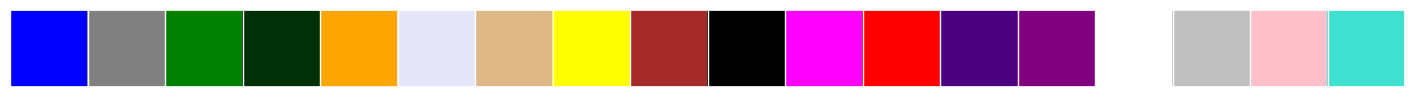

In [29]:
# make a list of the types
types = list(custom_colors.keys())

# loop through the types and count the number of values that match the type name
type_nums = []
for type_ in types:
    type_nums.append(sum(df['Type1']==type_))

# create data frame and sort in descending order by Count
data = {'Count': type_nums}
data_df = pd.DataFrame(data, index=types).sort_values(by='Count', ascending=False)

# get the types
types = data_df.index.to_list()

# rearrange the colors to match key order with "types" order
rearranged_colors = {key: custom_colors[key] for key in types}

# get color palette
sns.set(font_scale=1.25)
sns.set_palette(sns.color_palette(rearranged_colors.values()))
sns.palplot(sns.color_palette(rearranged_colors.values()),size=1)

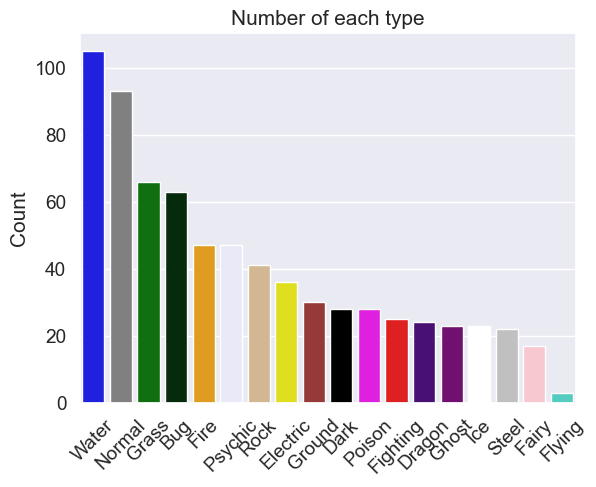

In [30]:
plt.title('Number of each type')
ax = sns.barplot(x=data_df.index, y='Count', data=data_df)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="center")
plt.show()

In [31]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, InputLayer
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model

In [32]:
# CNN
datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)

train_data = datagen.flow_from_dataframe(
    df,
    x_col='Filepath',
    y_col='Type1',
    target_size=(150, 150),
    color_mode='rgba',
    class_mode='sparse',
    batch_size=32,
    subset='training'
)

val_data = datagen.flow_from_dataframe(
    df,
    x_col='Filepath',
    y_col='Type1',
    target_size=(150, 150),
    color_mode='rgba',
    class_mode='sparse',
    batch_size=32,
    subset='validation'
)

Found 577 validated image filenames belonging to 18 classes.
Found 144 validated image filenames belonging to 18 classes.


In [15]:
# pretty bad when trying to do all 18 types
cnn_model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 4)),
    MaxPooling2D(2, 2),
    Conv2D(64, (3, 3), activation='relu', input_shape=(150, 150, 4)),
    MaxPooling2D(2, 2),
    Conv2D(128, (3, 3), activation='relu', input_shape=(150, 150, 4)),
    MaxPooling2D(2, 2),
    Flatten(),
    Dense(512, activation='relu'),
    Dense(18, activation='softmax')
])

cnn_model.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

history = cnn_model.fit(train_data, validation_data=val_data, epochs=10)

Epoch 1/10
19/19 [==============================] - 12s 577ms/step - loss: 3.0029 - accuracy: 0.1023 - val_loss: 2.8276 - val_accuracy: 0.1319
Epoch 2/10
19/19 [==============================] - 10s 536ms/step - loss: 2.7098 - accuracy: 0.1664 - val_loss: 2.7159 - val_accuracy: 0.1528
Epoch 3/10
19/19 [==============================] - 10s 538ms/step - loss: 2.4753 - accuracy: 0.2340 - val_loss: 2.7963 - val_accuracy: 0.1667
Epoch 4/10
19/19 [==============================] - 10s 538ms/step - loss: 1.9946 - accuracy: 0.3501 - val_loss: 3.2087 - val_accuracy: 0.1319
Epoch 5/10
19/19 [==============================] - 10s 548ms/step - loss: 1.3547 - accuracy: 0.5858 - val_loss: 3.7648 - val_accuracy: 0.1042
Epoch 6/10
19/19 [==============================] - 10s 536ms/step - loss: 0.7701 - accuracy: 0.7452 - val_loss: 6.0153 - val_accuracy: 0.1458
Epoch 7/10
19/19 [==============================] - 10s 520ms/step - loss: 0.3402 - accuracy: 0.8891 - val_loss: 7.3409 - val_accuracy: 0.1111

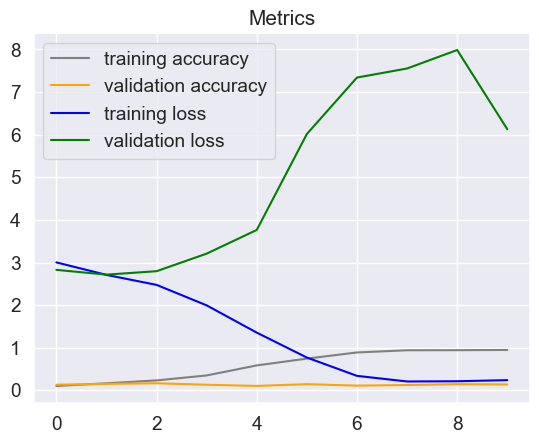

In [16]:
loss = history.history['loss']
accuracy = history.history['accuracy']
val_loss = history.history['val_loss']
val_accuracy = history.history['val_accuracy']
epochs = range(len(loss))

plt.plot(epochs, accuracy, label='training accuracy')
plt.plot(epochs, val_accuracy, label='validation accuracy')
plt.plot(epochs, loss, label='training loss')
plt.plot(epochs, val_loss, label='validation loss')
plt.legend()
plt.title('Metrics')
plt.show()

In [17]:
binary_df = df.query("Type1 == 'Fire' | Type1 == 'Water'")

train_data2 = datagen.flow_from_dataframe(
    binary_df,
    x_col='Filepath',
    y_col='Type1',
    target_size=(150, 150),
    color_mode='rgba',
    class_mode='sparse',
    batch_size=32,
    subset='training'
)

val_data2 = datagen.flow_from_dataframe(
    binary_df,
    x_col='Filepath',
    y_col='Type1',
    target_size=(150, 150),
    color_mode='rgba',
    class_mode='sparse',
    batch_size=32,
    subset='validation'
)

cnn_model2 = Sequential([
    Conv2D(32, (4, 4), activation='relu', input_shape=(150, 150, 4)),
    MaxPooling2D(2, 2),
    Conv2D(64, (4, 4), activation='relu', input_shape=(150, 150, 4)),
    MaxPooling2D(2, 2),
    Conv2D(128, (4, 4), activation='relu', input_shape=(150, 150, 4)),
    MaxPooling2D(2, 2),
    Flatten(),
    Dense(512, activation='relu'),
    Dense(1, activation='sigmoid')
])

cnn_model2.compile(optimizer='adam',
                  loss='binary_crossentropy',
                  metrics=['accuracy'])

history2 = cnn_model2.fit(train_data2, validation_data=val_data2, epochs=10)

Found 122 validated image filenames belonging to 2 classes.
Found 30 validated image filenames belonging to 2 classes.
Epoch 1/10
4/4 [==============================] - 4s 807ms/step - loss: 0.9614 - accuracy: 0.5082 - val_loss: 0.6585 - val_accuracy: 0.6000
Epoch 2/10
4/4 [==============================] - 3s 703ms/step - loss: 0.5613 - accuracy: 0.7377 - val_loss: 0.7947 - val_accuracy: 0.5667
Epoch 3/10
4/4 [==============================] - 3s 695ms/step - loss: 0.4754 - accuracy: 0.7213 - val_loss: 0.5694 - val_accuracy: 0.5667
Epoch 4/10
4/4 [==============================] - 3s 716ms/step - loss: 0.3625 - accuracy: 0.8033 - val_loss: 0.6500 - val_accuracy: 0.5667
Epoch 5/10
4/4 [==============================] - 3s 718ms/step - loss: 0.3156 - accuracy: 0.8279 - val_loss: 0.4072 - val_accuracy: 0.8667
Epoch 6/10
4/4 [==============================] - 3s 704ms/step - loss: 0.2762 - accuracy: 0.8770 - val_loss: 0.4590 - val_accuracy: 0.7000
Epoch 7/10
4/4 [=========================

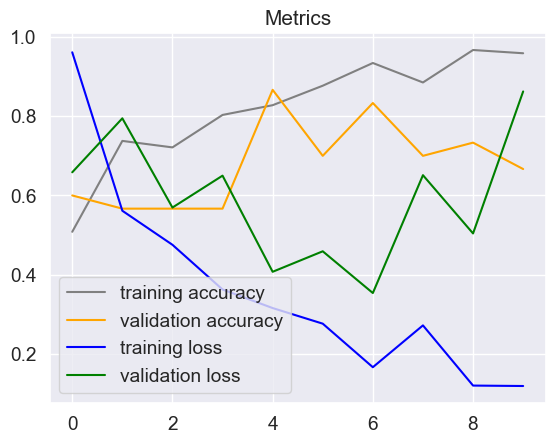

In [18]:
loss2 = history2.history['loss']
accuracy2 = history2.history['accuracy']
val_loss2 = history2.history['val_loss']
val_accuracy2 = history2.history['val_accuracy']
epochs2 = range(len(loss2))

plt.plot(epochs2, accuracy2, label='training accuracy')
plt.plot(epochs2, val_accuracy2, label='validation accuracy')
plt.plot(epochs2, loss2, label='training loss')
plt.plot(epochs2, val_loss2, label='validation loss')
plt.legend()
plt.title('Metrics')
plt.show()

In [ ]:
# KNN
from sklearn.neighbors import KNeighborsClassifier

knn_regular_df = KNeighborsClassifer()

In [ ]:
# Decision trees
from sklearn.tree import DecisionTreeClassifier

dt_regular_df = DecisionTreeClassifer()

In [ ]:
# Random forests
from sklearn.ensemble import RandomForestClassifier

rf_regular_df = RandomForestClassifier()

In [ ]:
# Ensemble of the above three